In [ ]:
"""Generation of training data for size 1 and 2"""
import ase.io
import itertools
from icet.tools import enumerate_structures

struct = ase.io.read('SrS.vasp')
cluster_list = [[['Sr','Pb']]*4,[['S']]*4]

idx =0
for structure in enumerate_structures(struct,sizes=range(3),chemical_symbols=list(itertools.chain(*cluster_list))):
    if structure.get_global_number_of_atoms == 8:
        ase.io.write('./size_1/POSCAR_' + str(idx),structure)
    elif structure.get_global_number_of_atoms == 16: 
        ase.io.write('./size_2/POSCAR_' + str(idx),structure)
    idx +=1
 

In [ ]:
"""Size 3 training data"""
import ase.io
import itertools
from icet.tools import enumerate_structures

struct = ase.io.read('SrS.vasp')
cluster_list = [[['Sr','Pb']]*4,[['S']]*4]

idx =54
for structure in enumerate_structures(struct,sizes=range(3,4),chemical_symbols=list(itertools.chain(*cluster_list))):
        ase.io.write('./size_3/POSCAR_' + str(idx),structure)
        idx +=1


In [42]:
"""Building CEM to compare with published work"""


"""Model Construction"""
import ase.io
from cem_functions_new import get_fit_data, get_cem_new, plot_eci
from icet import ClusterSpace, StructureContainer
import itertools
from icet.tools import enumerate_structures
import pandas as pd

energy_cols = ['STRUCTURE', 'ENERGY']
df_energy = pd.read_csv('cem_energies.txt',sep ='\t',usecols=energy_cols)

struct = ase.io.read('SrS.vasp')
cluster_list = [[['Sr','Pb']]*4,[['S']]*4]
cutoffs = [8,6]
cs = ClusterSpace(structure=struct, cutoffs=cutoffs, chemical_symbols=list(itertools.chain(*cluster_list)))
sc_site_energies = StructureContainer(cluster_space=cs)

index = 0
for structure in enumerate_structures(struct,sizes=range(3),chemical_symbols=list(itertools.chain(*cluster_list))):  
        if len(structure)==8:
             n_sites=4
        else:
            n_sites=8

        
        sc_site_energies.add_structure(structure, properties = {'dft_energies_per_fu': df_energy['ENERGY'][index]/n_sites})
            
        index = index + 1

opt = get_fit_data('omp', sc_site_energies)

print(opt)




============== CrossValidationEstimator ==============
seed                           : 42
fit_method                     : omp
standardize                    : True
n_target_values                : 54
n_parameters                   : 6
n_nonzero_parameters           : 6
parameters_norm                : 9.439982
target_values_std              : 0.2784586
rmse_train                     : 0.0004124358
R2_train                       : 0.999998
AIC                            : -834.4187
BIC                            : -822.4847
validation_method              : k-fold
n_splits                       : 10
rmse_train_final               : 0.000394769
rmse_validation                : 0.0004805798
R2_validation                  : 0.9999948
shuffle                        : True


/home/siddhartha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


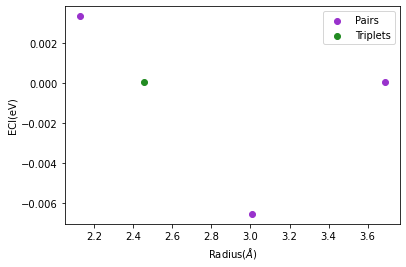

In [43]:
ce_site_energies = get_cem_new(opt,cs)

fig,ax = plot_eci(ce_site_energies)
fig.show()

#ce_site_energies.write('ce_site_energies')

Predicted energies for 631 structures


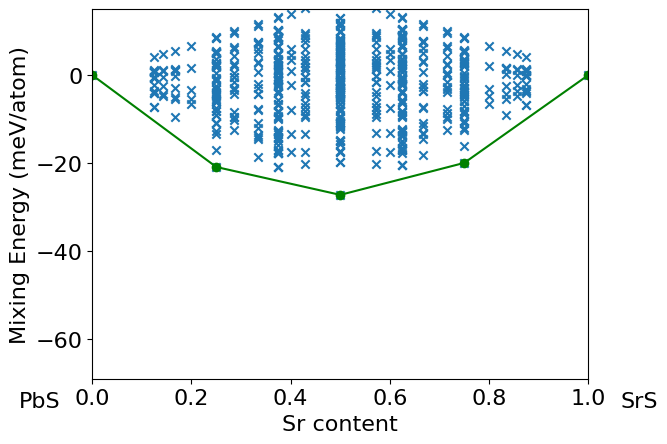

In [3]:
"""Convex Hull Generation"""

from icet import ClusterExpansion
from icet.tools import enumerate_structures
from icet.tools import ConvexHull
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

ce = ClusterExpansion.read('./ce_site_energies')
species = ['Sr', 'Pb']
structures = []
data = {'concentration': [], 'dft_energy': []}
cluster_space = ce.get_cluster_space_copy()
chemical_symbols = cluster_space.chemical_symbols
primitive_structure = cluster_space.primitive_structure

for structure in enumerate_structures(structure=primitive_structure,
                                      sizes=range(9),
                                      chemical_symbols=chemical_symbols):
    conc = structure.get_chemical_symbols().count('Sr') / (structure.get_chemical_symbols().count('Sr') +structure.get_chemical_symbols().count('Pb'))
    data['concentration'].append(conc)
    data['dft_energy'].append(ce.predict(structure))
    structures.append(structure)
print('Predicted energies for {} structures'.format(len(structures)))


raw_energies = np.array(data['dft_energy'])
concentrations = np.array(data['concentration'])
mixing_energies = np.zeros(len(raw_energies))

SrS_energy = raw_energies[0]
PbS_energy = raw_energies[1]
mixing_energies = raw_energies - (concentrations*SrS_energy + (1-concentrations)*PbS_energy)

hull = ConvexHull(concentrations,mixing_energies)

mpl.rcParams.update({'font.size': 16})
fig, ax = plt.subplots()
fig.text(0.01,0.05,"PbS")
fig.text(0.95,0.05,"SrS")
ax.set_xlabel(r'Sr content')
ax.set_ylabel(r'Mixing Energy (meV/atom)')
ax.set_xlim([0, 1])
ax.set_ylim([-69, 15])
ax.scatter(concentrations,  1e3*mixing_energies, marker='x')
ax.plot(hull.concentrations, 1e3* hull.energies, '-o', color='green')
fig.savefig('mixing_energy_predicted.pdf',dpi =500,bbox_inches='tight')